# Ensemble Learning - XGBoost 

### 강의 자료 속 나온 3개의 수도 코드 구현에 집중 

### Algorithm 1 : Exact Greedy Algorithm for Split Finding 

Input : I, instance set of current node 
Input : d, feature dimension 

1. gain <- 0 
2. G $\leftarrow \sum_{i \in I}g_i$, H $\leftarrow \sum_{i \in I} h_i$ 
3. for k = 1 to m do :
- $G_L \leftarrow 0, H_L \leftarrow 0$ 
- for j in sorted(I, by $x_{jk}$) do 

> $G_L \leftarrow G_L + g_j, H_L \leftarrow H_L + h_j$

> $G_R \leftarrow G - G_L, H_R \leftarrow H - H_L$ 

> score $\leftarrow$ max(score, $\frac{G_L^2}{H_L + \lambda} + \frac{G_R^2}{H_R + \lambda} - \frac{G^2}{H + \lambda}) $ 

> end 
- end 

output : Split with max score 

**구현해야 하는 것**
- Loss function : $l(y_i, \hat y_i^{t-1} + f_t(x_i))$ 
- $G_L, G_R$ : 손실함수의 1차 미분의 좌측 합, 1차 미분의 나머지 합 
- $H_L, H_R$ : 손실함수의 2차 미분의 좌측 합, 2차 미분의 나머지 합 
- $\lambda$ : $\rho(f_k) = \gamma T + \frac{1}{2} \lambda ||w||^2$ 에서의 $\lambda$ 값
> $\gamma, \lambda$ : Parameter.

**필요한 것** 
- CART Tree 
- Loss 함수 정의 : 여기선 간단한 OLS을 채택하겠음. 

> g = f(x) - y : 예측값 - 실제값 

> h = 1 : 상수 

> f(x) = 모든 트리의 Node w 값의 합. CART Tree 알고리즘으로 구하기 

Q1. w의 값은 Leaf node 별 가중치인데, 이것은 계산해야하는 값인가 혹은 주어지는 값인가? 계산하는 값이라면 어떻게 계산할 것인가? Adaboost와 동일하게 에러율을 통해 계산하면 되나? 

혹시 w를 EM 알고리즘처럼 점차 값을 줄여나가야 하나? 


각 트리를 각 특성마다 Stump tree 형태로 구분하여 가중치를 구하는 방법은? 
이러면 Adaboost에서 가중치 $\alpha$ 를 구했던 방법을 적용할 수 있을텐데.
모든 leaf들의 가중치를 더한 후 정규화했을 때, 가장 가까운 class 의 값에다 분류하는 거지. 그럼 f(x)의 값이 정수가 아닐 수 있겠네. 아 이것도 문제가 있다. 이진 분류면 문제 없지만 다진 분류일 경우 class 순서(0,1,2,3,...)가 수치상 의미를 가지는 건 아니니까. 결국 -1, +1 처럼 이다, 아니다만 구분할 수 있겠네. 

일단 위의 논의는 이진 분류로 축약해서 생각하자. 다진 분류까지 한꺼번에 생각하긴 어렵겠다. 
이진 분류라면 Stump-tree를 통한 가중치 부여를 통해서 해결할 수 있을까? 
아 안된다. Adaboost의 가중치($\alpha$)는 특정 특성의 임의의 기준값으로 분류했을 때의 에러율에 비례하는 것인데, node w의 값은 +1 / -1 클래스의 값에 따라 서로 다르게 분류되어야 하니까. 오 잠시만 가중치에 class 값을 곱하면 되는 거 아닌가. 

CART가 각 노드에 따라 Yes/No로 이진 분류가 되는 방식이라면, Node별의 가중치만 알면 최종 leaf node의 값을 구할 수 있는 것 아닐까?!
그럼 문제는 Node별 가중치를 어떻게 구할 것인가! 
변수의 중요도로? 변수 자체의 중요도는 계산할 수 있어도, 변수를 어떤 기준으로 나눴는지 구분이 될까? 변수의 중요도는 Information gain을 기반으로 중요도를 산정하는 것. 


Q2. 문제는 첫 예측을 끝내고 두번째 함수($f_2(x)$)를 추가할 때 발생하네. 
클래스를 0,1,2 와 같이 표현했다면 잔차에선 -2, -1 과 같이 이전에 없던 분류값이 생겨버림. 

여전히 잔차를 어떻게 해석할 것인가에 대해서 막히네. Gradient boosting 부터 해결되야 그 다음 boost 방식을 풀 수 있겠다. 

**함수의 형태** 





In [ ]:
# stump_tree 함수 구현 
def stump_tree(data) : 
    chose_var = data[np.random.choice(range(len(data)))]
    chose_att = np.random.choice(range(np.shape(data)[1]-1))
    crit = chose_var[chose_att]
    
    left = [] 
    right = [] 
    result = np.zeros(len(data))
    for index in range(len(data)) : 
        if data[index][chose_att] > crit : right.append(index)
        else : left.append(index)
    
    right_result = [1 if data[right][i,-1] == 1 else 0 for i in range(len(right)) ] 
    left_result = [1 if data[left][i,-1] == -1 else 0 for i in range(len(left)) ]
    if np.sum(right_result) + np.sum(left_result) > len(data)/2 : 
        result[right] = 1 
        result[left] = -1 
        direction = "right" 
    else : 
        result[right] = -1 
        result[left] = 1 
        direction = "left"
    return result, chose_att, crit, direction 

def cal_stump_tree(vector, chose_att, crit, direction) :
    if vector[chose_att] > crit :
        if direction == "right":  return 1
        else : return -1 
        
    else : 
        if direction == "right" : return -1 
        else : return 1 

In [6]:
import numpy as np
import pandas as pd
import random as rand

from sklearn.datasets import load_iris
iris = load_iris()
X = load_iris()['data']
y = load_iris()["target"]

In [15]:

from sklearn import tree # for decision tree models


weight = {0: 0.3, 1 : 0.1, 2: 0.6}

model = tree.DecisionTreeClassifier(max_depth = 2, class_weight = weight)
clf = model.fit(X,y)
pred_label = model.predict(X)


In [4]:
pred_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

[Text(0.4, 0.8333333333333334, 'petal length (cm) <= 2.45\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]\nclass = setosa'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 50\nvalue = [50, 0, 0]\nclass = setosa'),
 Text(0.6, 0.5, 'petal width (cm) <= 1.75\ngini = 0.5\nsamples = 100\nvalue = [0, 50, 50]\nclass = versicolor'),
 Text(0.4, 0.16666666666666666, 'gini = 0.168\nsamples = 54\nvalue = [0, 49, 5]\nclass = versicolor'),
 Text(0.8, 0.16666666666666666, 'gini = 0.043\nsamples = 46\nvalue = [0, 1, 45]\nclass = virginica')]

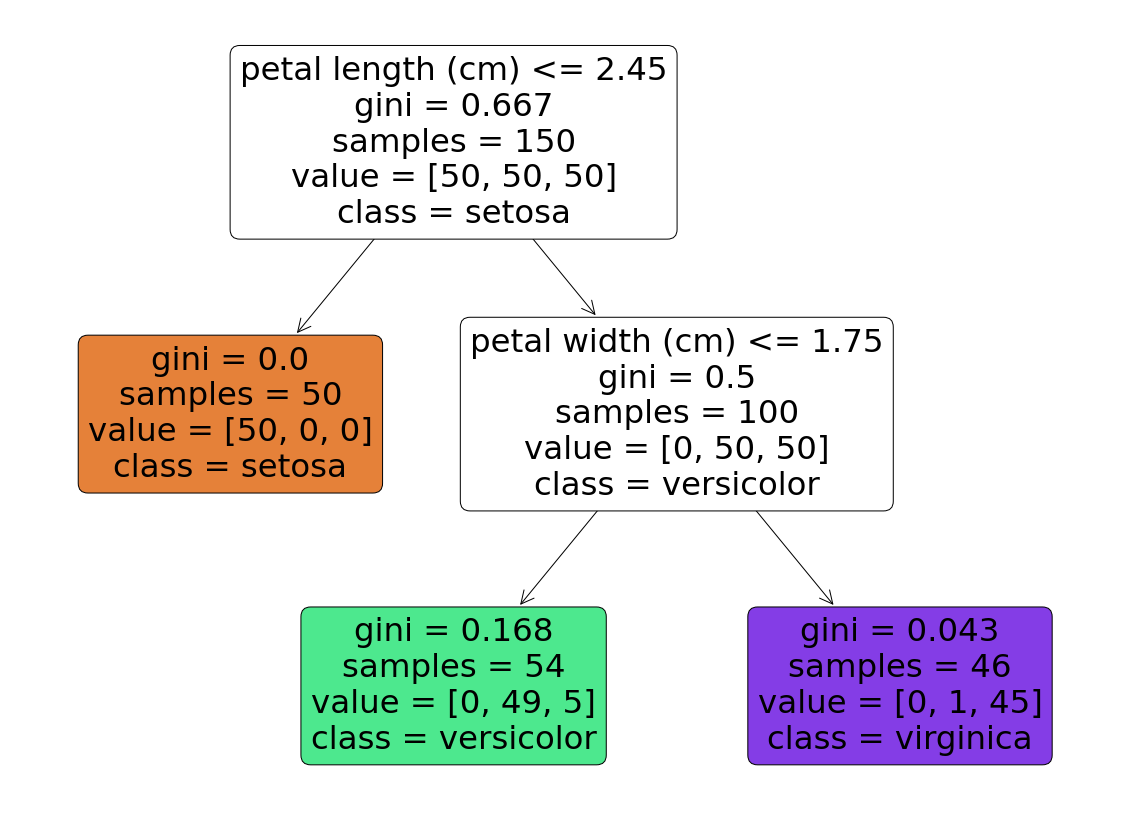

In [9]:
import matplotlib.pyplot as plt
from sklearn import tree

plt.figure( figsize=(20,15) )
tree.plot_tree(model, 
               class_names=iris.target_names,
               feature_names=iris.feature_names,
               impurity=True, filled=True,
               rounded=True)